In [0]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet
from unet import UNet

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [15]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(128, 128)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

transform_observe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    torchvision.transforms.ToTensor()
])


# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((212, 212)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])
# anno_norm =  torchvision.transforms.Normalize(mean=[0.00202586], std=[0.00176733])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))

        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
            # anno = transform_resize(anno)     # unet resize

        anno[anno>0] = 1
        # anno_reshaped = np.zeros((self.num_of_classes, anno.shape[1], anno.shape[2]))
        # for i in range(self.num_of_classes):
        #     anno_reshaped[i, :, :][anno[0] == i] = 1

        sample = {"image": img, "annotation": anno}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)
dataset_observe = CustomDataset(img_list, anno_list, 2, transform=transform_observe)

In [0]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 70,
    shuffle=True
)

dataloader_observe = torch.utils.data.DataLoader(
    dataset_observe,
    batch_size = 1,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(70, 3, 128, 128)


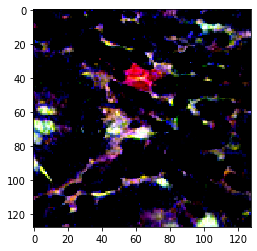

torch.Size([70, 1, 128, 128])


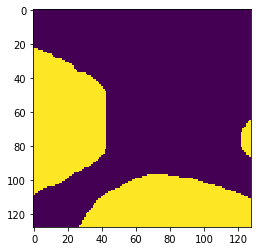

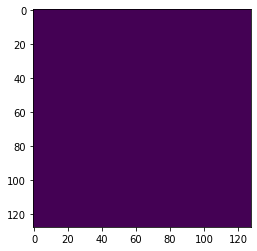

In [18]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()
plt.imshow(batch_data['annotation'][1][0])
plt.show()

In [0]:
net = SegNet(1, n_init_features=3) # input channels, output channels
# net = UNet(2, n_init_features=3)
if use_cuda:
    net.cuda()

In [0]:
LEARNING_RATE = 0.001
# criterion = nn.CrossEntropyLoss() for multiple class
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), 5e-5, (0.9, 0.999),  eps=1e-08, weight_decay=4e-4)

train loss:  0.7227303385734558


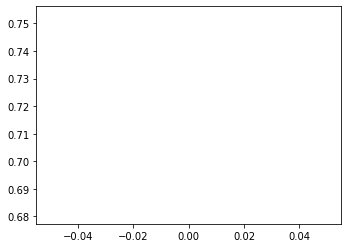

Train, it: 0 loss: 0.72
train loss:  0.6968634128570557


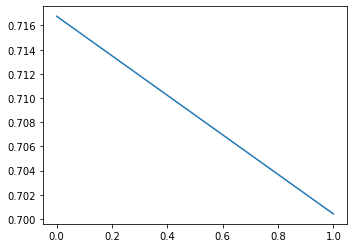

Train, it: 1 loss: 0.70
train loss:  0.6890681982040405


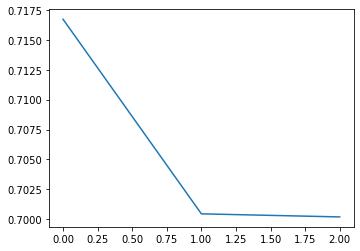

Train, it: 2 loss: 0.70
train loss:  0.6894711256027222


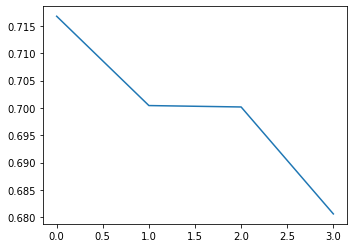

Train, it: 3 loss: 0.68
train loss:  0.700009286403656


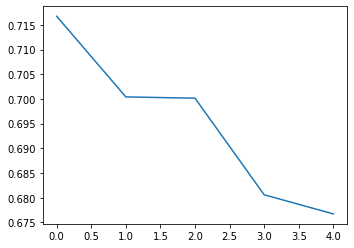

Train, it: 4 loss: 0.68
train loss:  0.6701667308807373


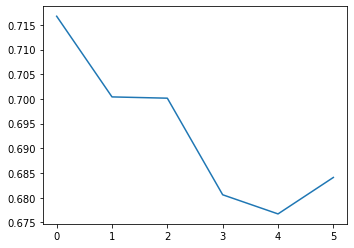

Train, it: 5 loss: 0.68
train loss:  0.6700299978256226


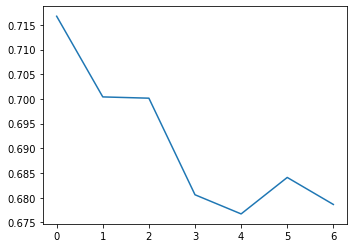

Train, it: 6 loss: 0.68
train loss:  0.6523234844207764


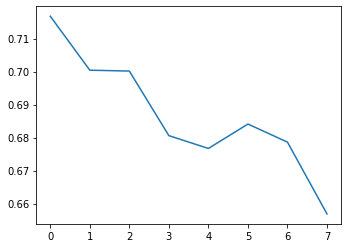

Train, it: 7 loss: 0.66
train loss:  0.6854161620140076


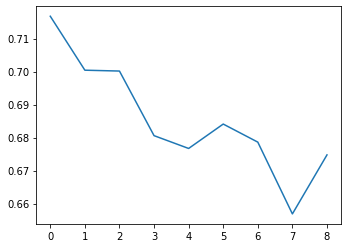

Train, it: 8 loss: 0.67
train loss:  0.6410984396934509


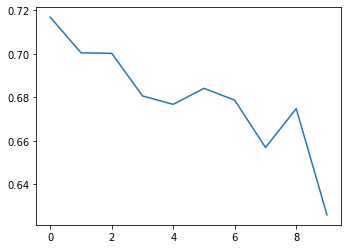

Train, it: 9 loss: 0.63
train loss:  0.6335045099258423


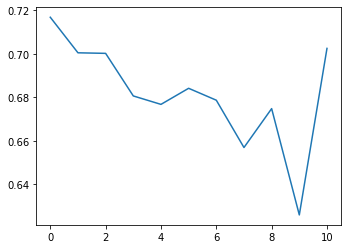

Train, it: 10 loss: 0.70
train loss:  0.6423229575157166


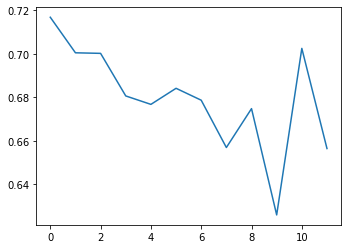

Train, it: 11 loss: 0.66
train loss:  0.6545925736427307


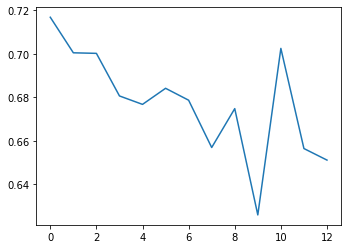

Train, it: 12 loss: 0.65
train loss:  0.6384003162384033


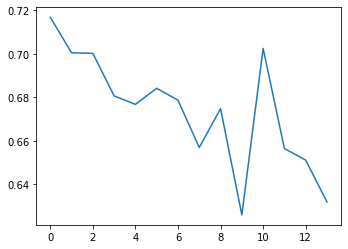

Train, it: 13 loss: 0.63
train loss:  0.6268114447593689


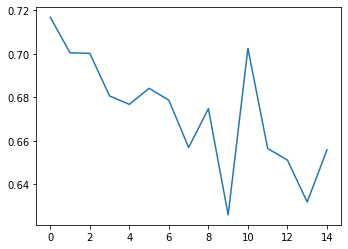

Train, it: 14 loss: 0.66
train loss:  0.6531635522842407


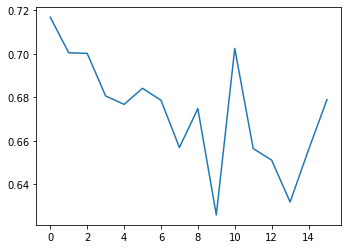

Train, it: 15 loss: 0.68
train loss:  0.6366991400718689


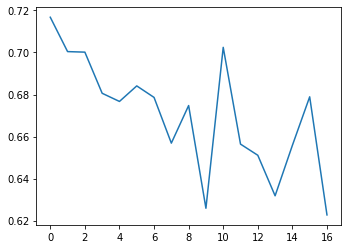

Train, it: 16 loss: 0.62
train loss:  0.6121276617050171


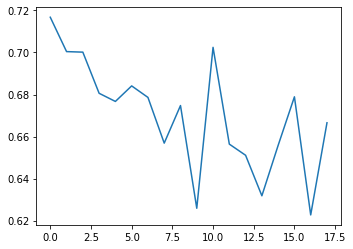

Train, it: 17 loss: 0.67
train loss:  0.5975584983825684


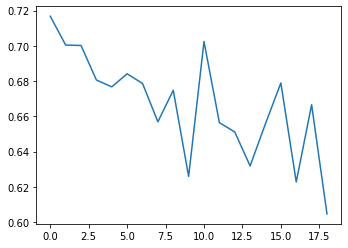

Train, it: 18 loss: 0.60
train loss:  0.6167718172073364


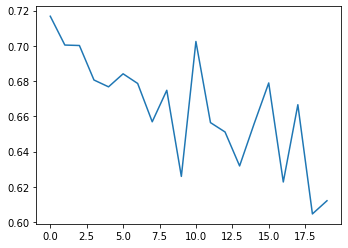

Train, it: 19 loss: 0.61
train loss:  0.5750516653060913


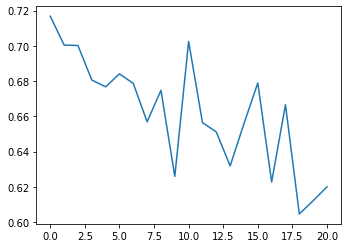

Train, it: 20 loss: 0.62
train loss:  0.5901558995246887


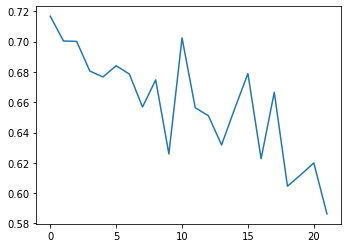

Train, it: 21 loss: 0.59
train loss:  0.5738270282745361


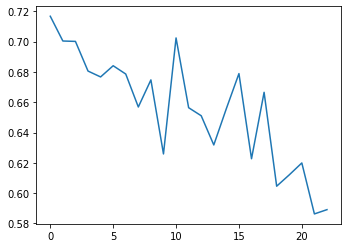

Train, it: 22 loss: 0.59
train loss:  0.5834254026412964


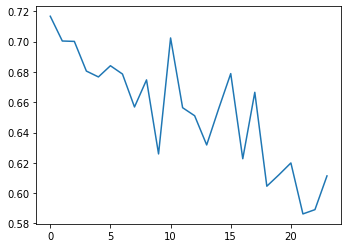

Train, it: 23 loss: 0.61
train loss:  0.5665841102600098


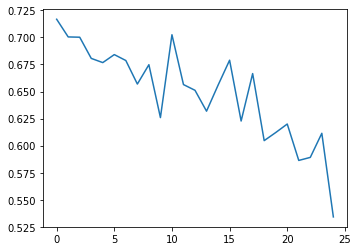

Train, it: 24 loss: 0.53
train loss:  0.5957584977149963


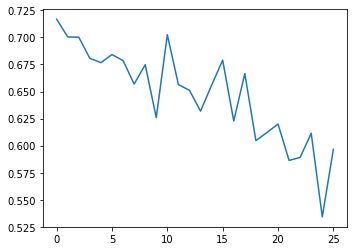

Train, it: 25 loss: 0.60
train loss:  0.5272283554077148


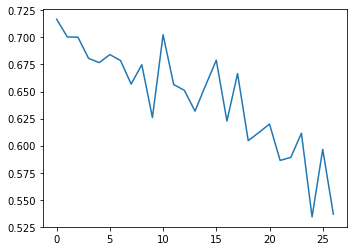

Train, it: 26 loss: 0.54
train loss:  0.527672529220581


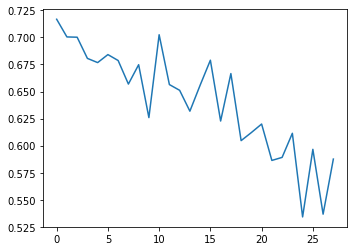

Train, it: 27 loss: 0.59
train loss:  0.577265739440918


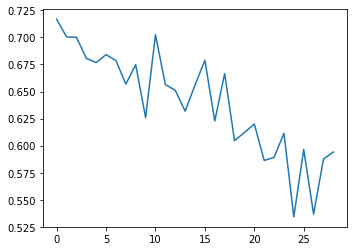

Train, it: 28 loss: 0.59
train loss:  0.5780976414680481


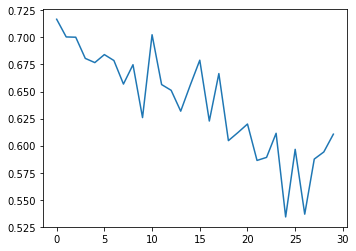

Train, it: 29 loss: 0.61
train loss:  0.5170678496360779


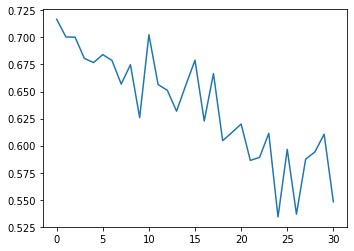

Train, it: 30 loss: 0.55
train loss:  0.5040263533592224


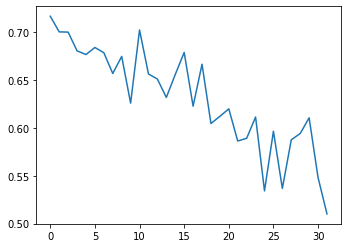

Train, it: 31 loss: 0.51
train loss:  0.4978681206703186


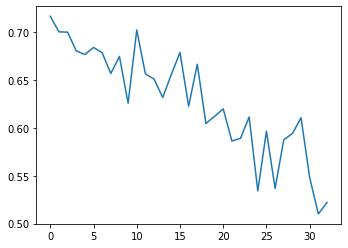

Train, it: 32 loss: 0.52
train loss:  0.5373109579086304


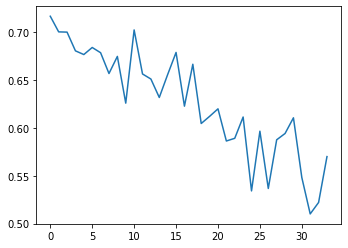

Train, it: 33 loss: 0.57
train loss:  0.5152668952941895


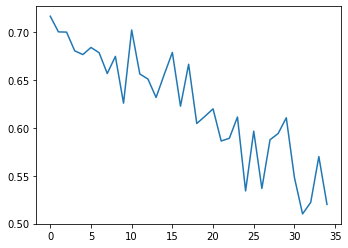

Train, it: 34 loss: 0.52
train loss:  0.5291732549667358


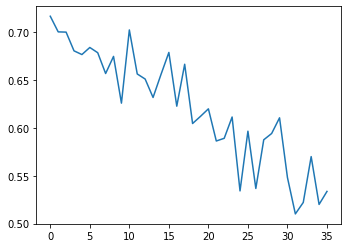

Train, it: 35 loss: 0.53
train loss:  0.5349025130271912


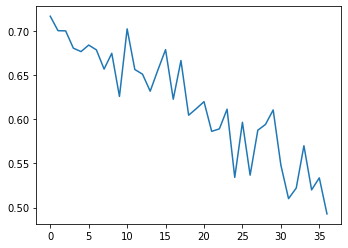

Train, it: 36 loss: 0.49
train loss:  0.46944546699523926


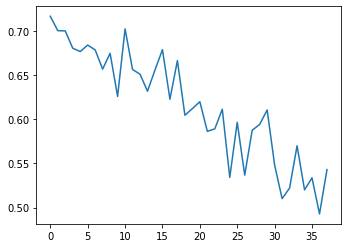

Train, it: 37 loss: 0.54
train loss:  0.48064184188842773


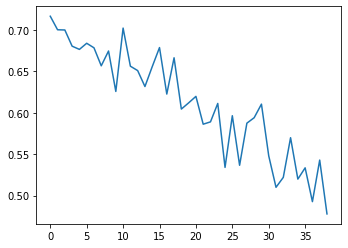

Train, it: 38 loss: 0.48
train loss:  0.5039921998977661


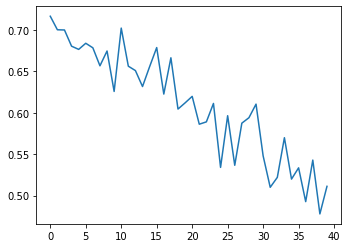

Train, it: 39 loss: 0.51
train loss:  0.5100434422492981


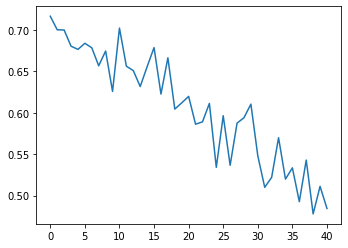

Train, it: 40 loss: 0.48
train loss:  0.4839349091053009


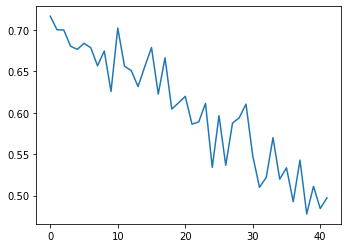

Train, it: 41 loss: 0.50
train loss:  0.4769996702671051


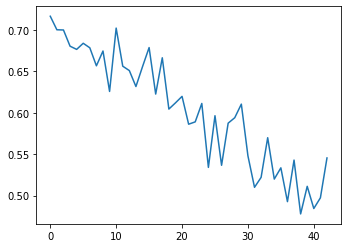

Train, it: 42 loss: 0.55
train loss:  0.5023273229598999


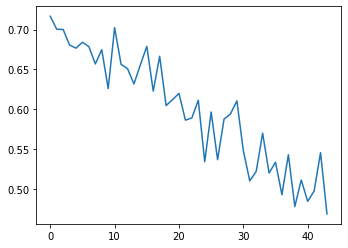

Train, it: 43 loss: 0.47
train loss:  0.4431665241718292


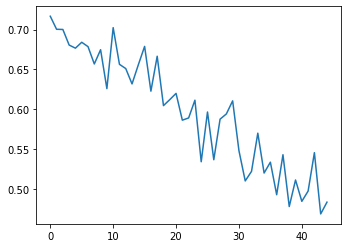

Train, it: 44 loss: 0.48
train loss:  0.4900708794593811


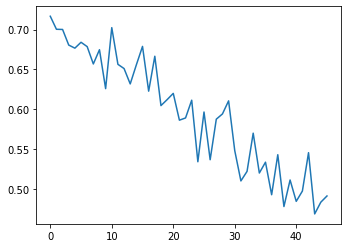

Train, it: 45 loss: 0.49
train loss:  0.5167334675788879


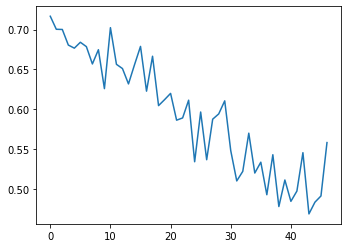

Train, it: 46 loss: 0.56
train loss:  0.4637257754802704


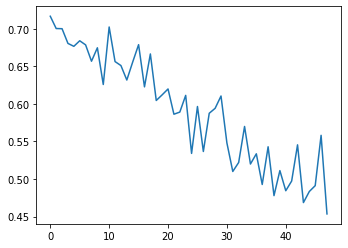

Train, it: 47 loss: 0.45
train loss:  0.547685980796814


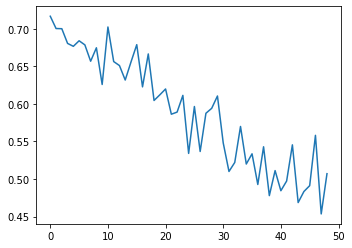

Train, it: 48 loss: 0.51
train loss:  0.4860507547855377


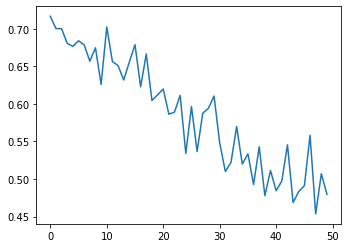

Train, it: 49 loss: 0.48
train loss:  0.4675990045070648


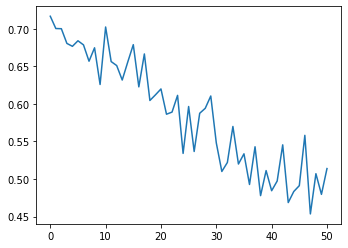

Train, it: 50 loss: 0.51
train loss:  0.42949628829956055


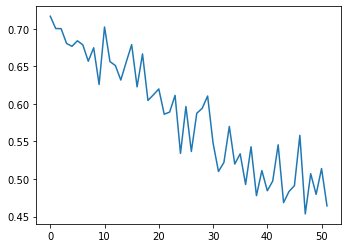

Train, it: 51 loss: 0.46
train loss:  0.4287180006504059


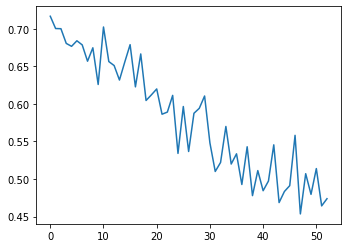

Train, it: 52 loss: 0.47
train loss:  0.4589853584766388


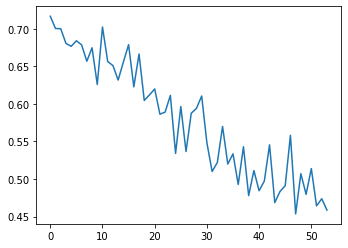

Train, it: 53 loss: 0.46
train loss:  0.441704660654068


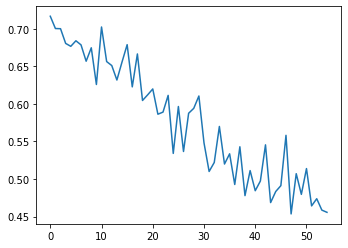

Train, it: 54 loss: 0.46
train loss:  0.4363374710083008


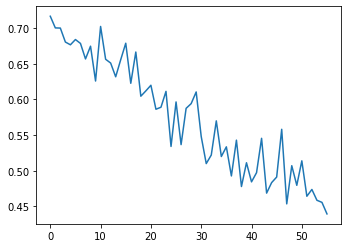

Train, it: 55 loss: 0.44
train loss:  0.4459032118320465


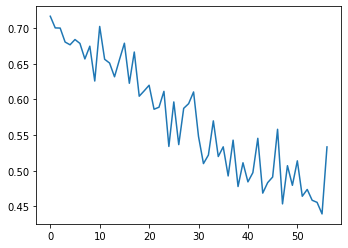

Train, it: 56 loss: 0.53
train loss:  0.4829612672328949


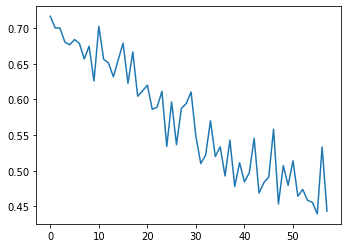

Train, it: 57 loss: 0.44
train loss:  0.44261154532432556


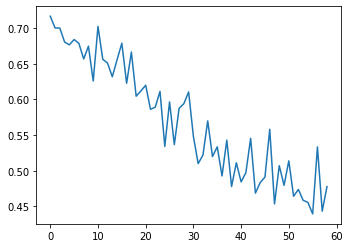

Train, it: 58 loss: 0.48
train loss:  0.4320414066314697


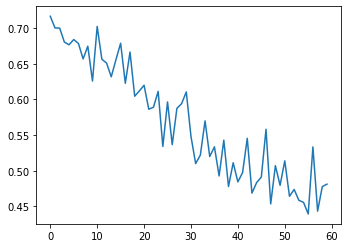

Train, it: 59 loss: 0.48
train loss:  0.46048736572265625


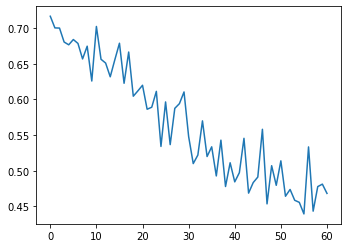

Train, it: 60 loss: 0.47
train loss:  0.4189203083515167


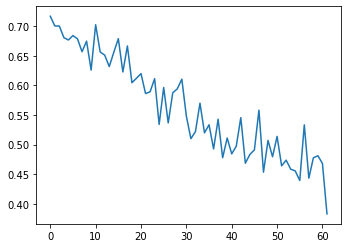

Train, it: 61 loss: 0.38
train loss:  0.4281727969646454


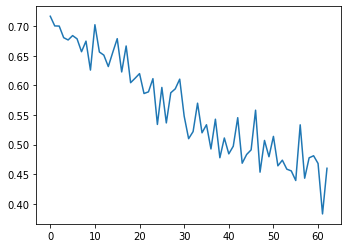

Train, it: 62 loss: 0.46
train loss:  0.4328479766845703


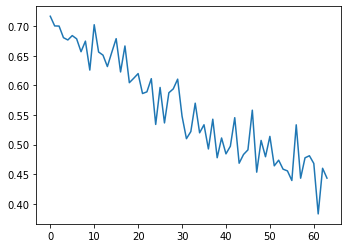

Train, it: 63 loss: 0.44
train loss:  0.4323228597640991


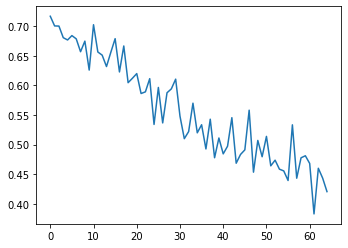

Train, it: 64 loss: 0.42
train loss:  0.4272823929786682


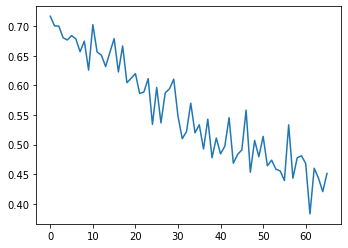

Train, it: 65 loss: 0.45
train loss:  0.41988328099250793


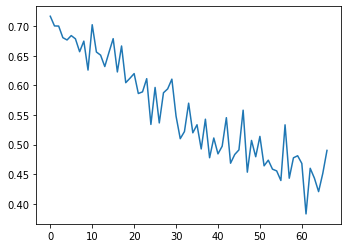

Train, it: 66 loss: 0.49
train loss:  0.46316614747047424


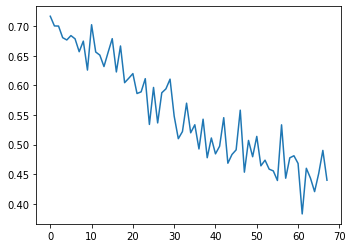

Train, it: 67 loss: 0.44
train loss:  0.45214059948921204


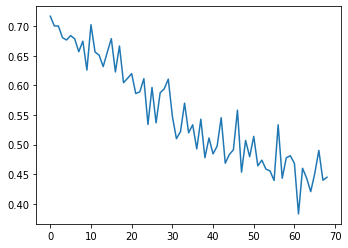

Train, it: 68 loss: 0.44
train loss:  0.4480647146701813


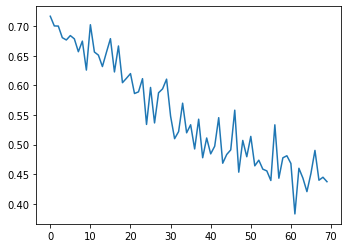

Train, it: 69 loss: 0.44
train loss:  0.4407438039779663


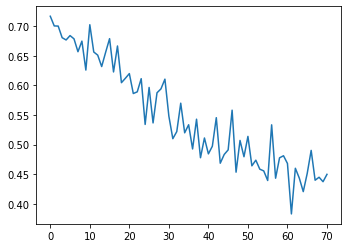

Train, it: 70 loss: 0.45
train loss:  0.41318124532699585


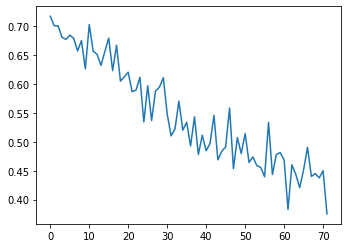

Train, it: 71 loss: 0.38
train loss:  0.40560248494148254


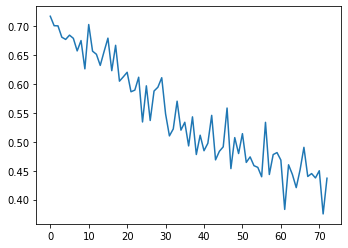

Train, it: 72 loss: 0.44
train loss:  0.40074947476387024


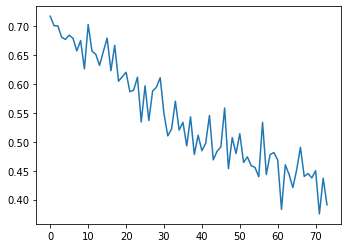

Train, it: 73 loss: 0.39
train loss:  0.44877707958221436


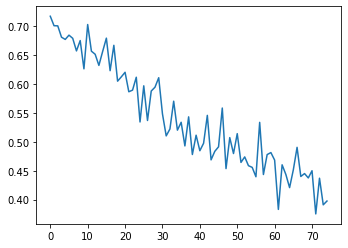

Train, it: 74 loss: 0.40
train loss:  0.40275877714157104


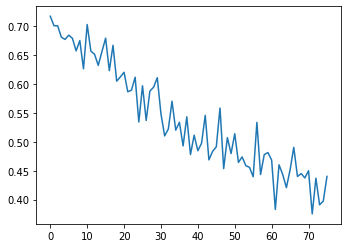

Train, it: 75 loss: 0.44
train loss:  0.36940568685531616


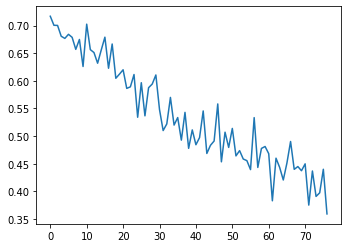

Train, it: 76 loss: 0.36
train loss:  0.41227325797080994


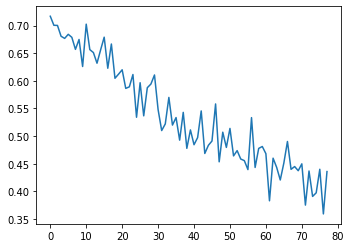

Train, it: 77 loss: 0.44
train loss:  0.39504683017730713


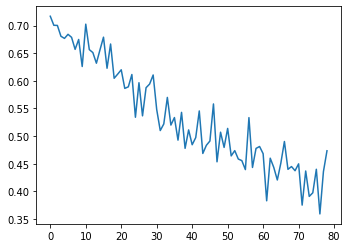

Train, it: 78 loss: 0.47
train loss:  0.4134816527366638


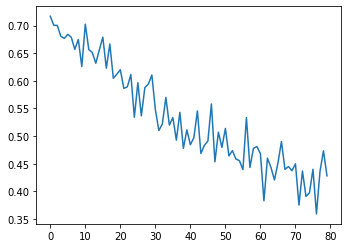

Train, it: 79 loss: 0.43
train loss:  0.4353598356246948


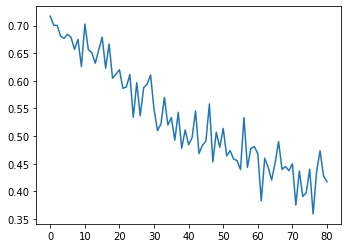

Train, it: 80 loss: 0.42
train loss:  0.4187678098678589


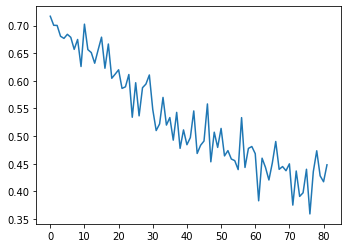

Train, it: 81 loss: 0.45
train loss:  0.4195716381072998


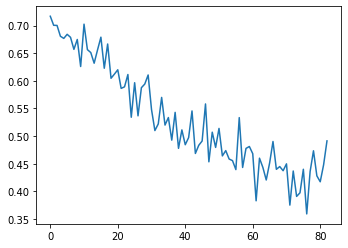

Train, it: 82 loss: 0.49
train loss:  0.4608166217803955


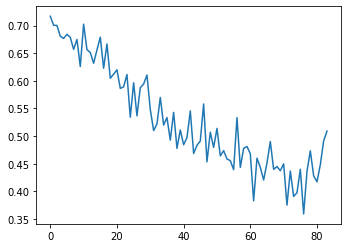

Train, it: 83 loss: 0.51
train loss:  0.4088825583457947


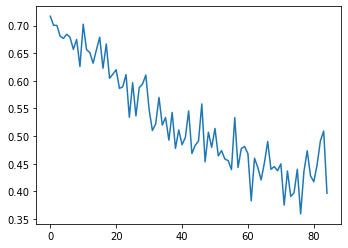

Train, it: 84 loss: 0.40
train loss:  0.4591168463230133


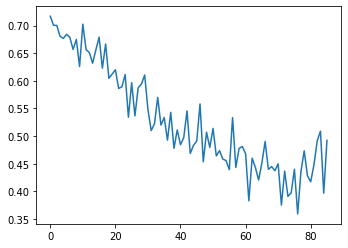

Train, it: 85 loss: 0.49
train loss:  0.42619481682777405


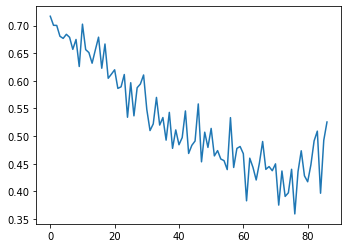

Train, it: 86 loss: 0.53
train loss:  0.43112820386886597


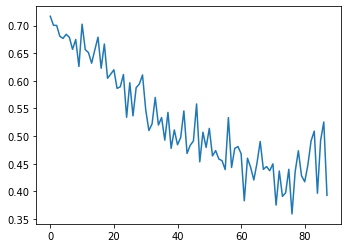

Train, it: 87 loss: 0.39
train loss:  0.5249324440956116


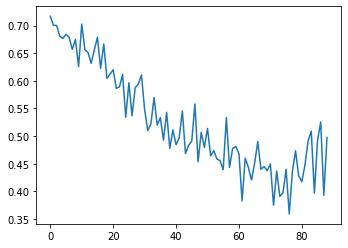

Train, it: 88 loss: 0.50
train loss:  0.43828439712524414


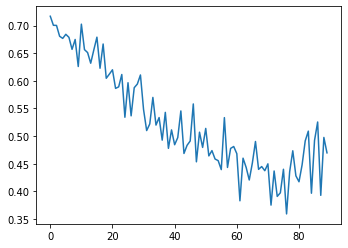

Train, it: 89 loss: 0.47
train loss:  0.4408518671989441


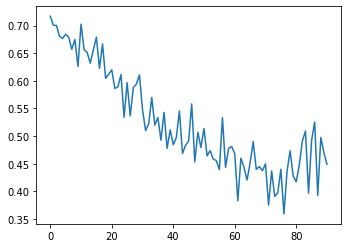

Train, it: 90 loss: 0.45
train loss:  0.40888339281082153


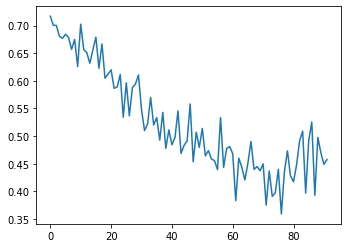

Train, it: 91 loss: 0.46
train loss:  0.42941778898239136


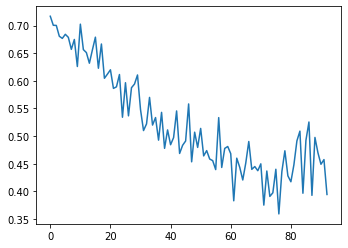

Train, it: 92 loss: 0.39
train loss:  0.3731766939163208


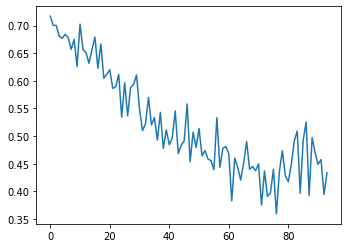

Train, it: 93 loss: 0.43
train loss:  0.42382463812828064


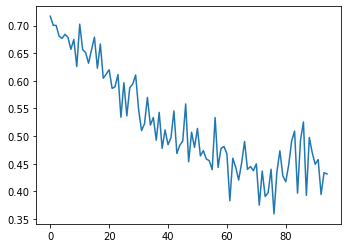

Train, it: 94 loss: 0.43
train loss:  0.3907901346683502


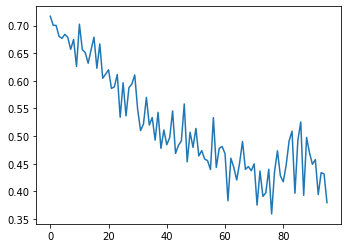

Train, it: 95 loss: 0.38
train loss:  0.3570994734764099


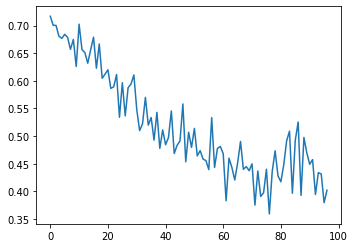

Train, it: 96 loss: 0.40
train loss:  0.41990476846694946


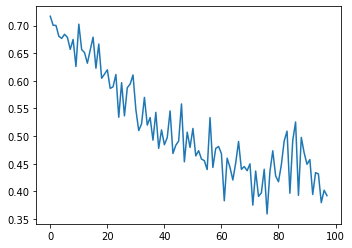

Train, it: 97 loss: 0.39
train loss:  0.38851410150527954


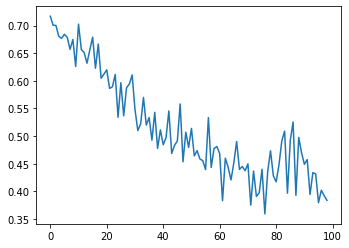

Train, it: 98 loss: 0.38
train loss:  0.4403778612613678


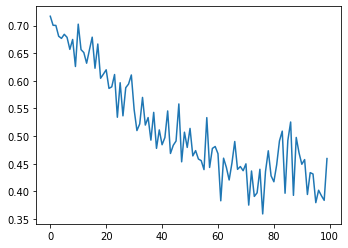

Train, it: 99 loss: 0.46
train loss:  0.40021947026252747


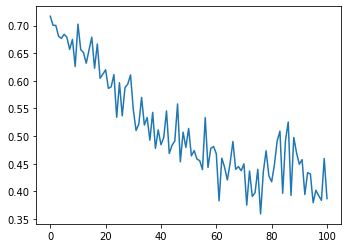

Train, it: 100 loss: 0.39
train loss:  0.415865421295166


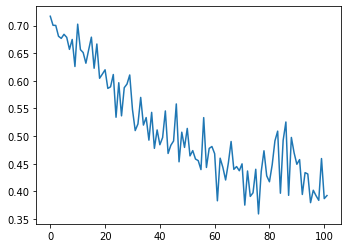

Train, it: 101 loss: 0.39
train loss:  0.38909879326820374


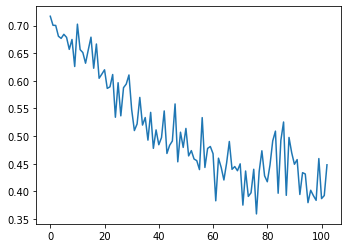

Train, it: 102 loss: 0.45
train loss:  0.3974978029727936


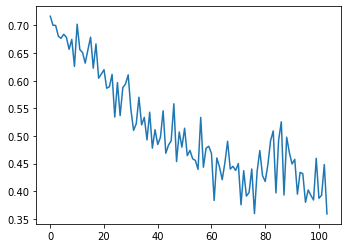

Train, it: 103 loss: 0.36
train loss:  0.3900642991065979


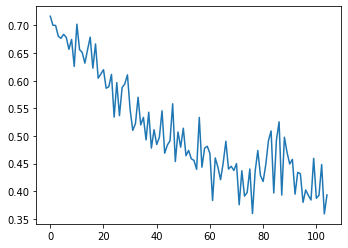

Train, it: 104 loss: 0.39
train loss:  0.3977717459201813


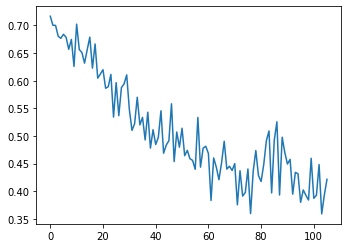

Train, it: 105 loss: 0.42
train loss:  0.3704710900783539


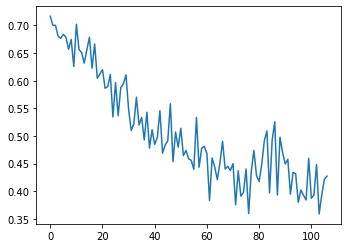

Train, it: 106 loss: 0.43
train loss:  0.3475089371204376


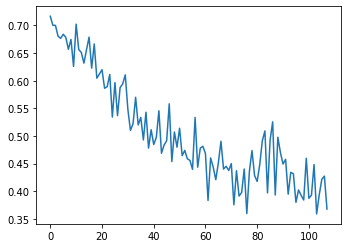

Train, it: 107 loss: 0.37
train loss:  0.4117342233657837


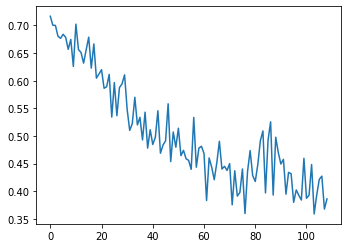

Train, it: 108 loss: 0.39
train loss:  0.3983038365840912


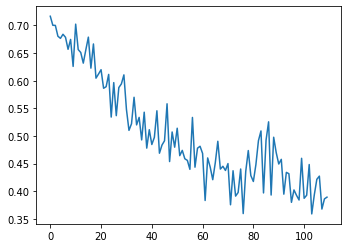

Train, it: 109 loss: 0.39
train loss:  0.40098294615745544


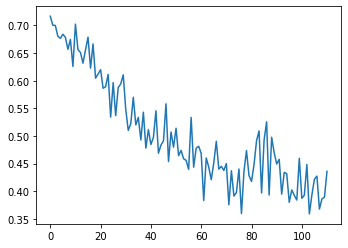

Train, it: 110 loss: 0.44
train loss:  0.3476499319076538


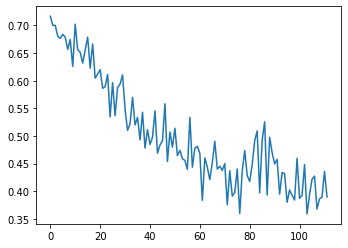

Train, it: 111 loss: 0.39
train loss:  0.35020706057548523


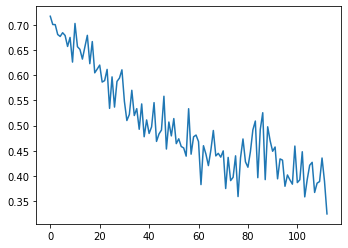

Train, it: 112 loss: 0.32
train loss:  0.354507714509964


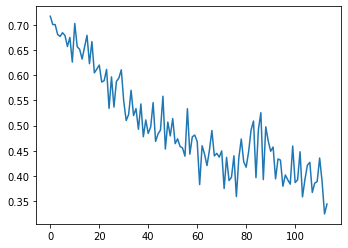

Train, it: 113 loss: 0.34
train loss:  0.3927815556526184


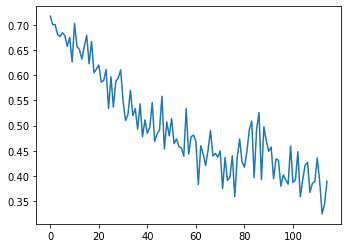

Train, it: 114 loss: 0.39
train loss:  0.41755211353302


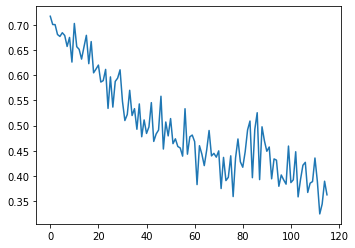

Train, it: 115 loss: 0.36
train loss:  0.3768390119075775


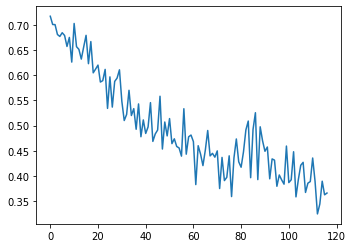

Train, it: 116 loss: 0.37
train loss:  0.33976471424102783


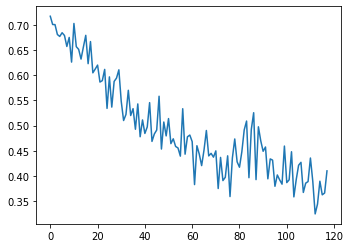

Train, it: 117 loss: 0.41
train loss:  0.3319225609302521


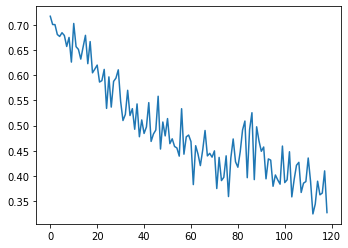

Train, it: 118 loss: 0.33
train loss:  0.38009729981422424


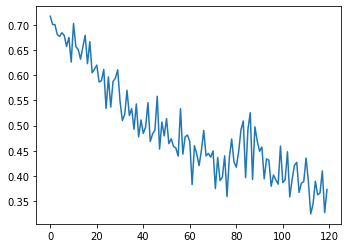

Train, it: 119 loss: 0.37
train loss:  0.3739592730998993


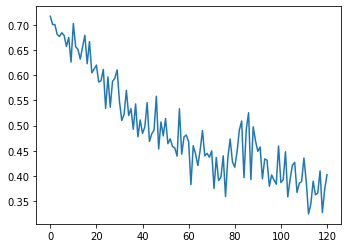

Train, it: 120 loss: 0.40
train loss:  0.3286888599395752


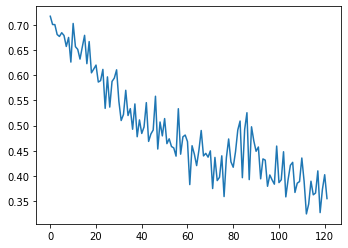

Train, it: 121 loss: 0.36
train loss:  0.3910955488681793


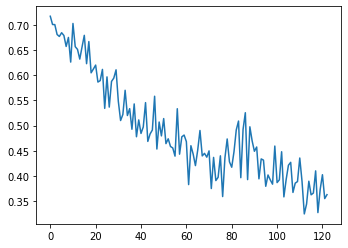

Train, it: 122 loss: 0.36
train loss:  0.37205615639686584


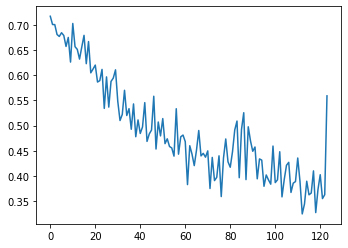

Train, it: 123 loss: 0.56
train loss:  0.35759618878364563


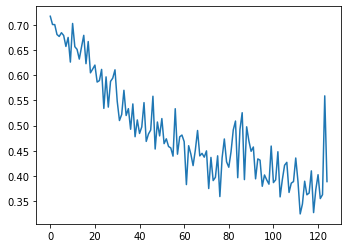

Train, it: 124 loss: 0.39
train loss:  0.3885587453842163


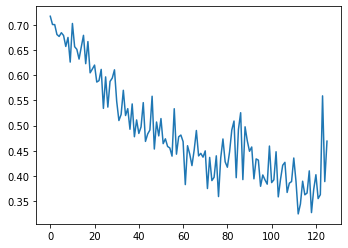

Train, it: 125 loss: 0.47
train loss:  0.3632586598396301


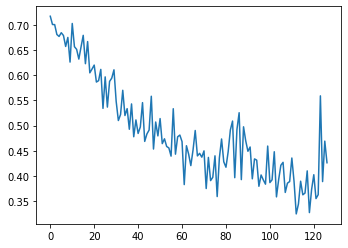

Train, it: 126 loss: 0.43
train loss:  0.4014478921890259


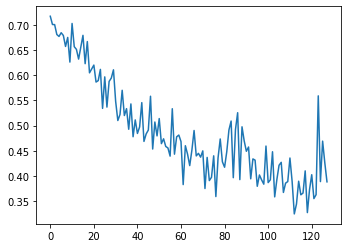

Train, it: 127 loss: 0.39
train loss:  0.359536349773407


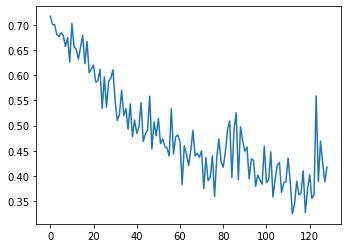

Train, it: 128 loss: 0.42
train loss:  0.39070576429367065


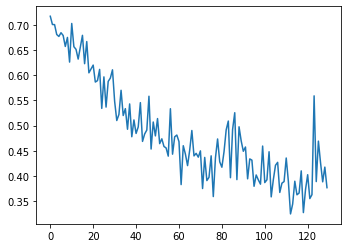

Train, it: 129 loss: 0.38
train loss:  0.3466464877128601


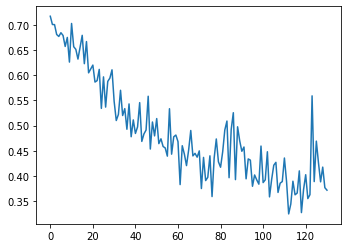

Train, it: 130 loss: 0.37
train loss:  0.35435405373573303


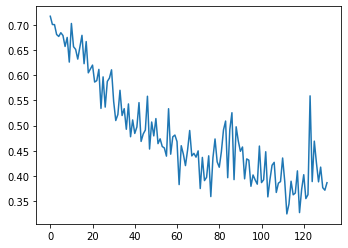

Train, it: 131 loss: 0.39
train loss:  0.37806227803230286


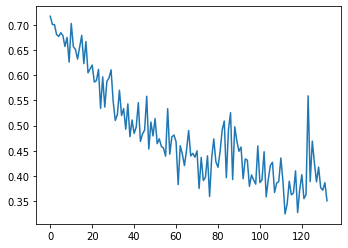

Train, it: 132 loss: 0.35
train loss:  0.37761011719703674


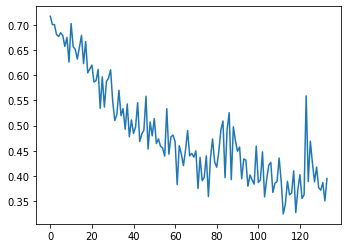

Train, it: 133 loss: 0.40
train loss:  0.34043779969215393


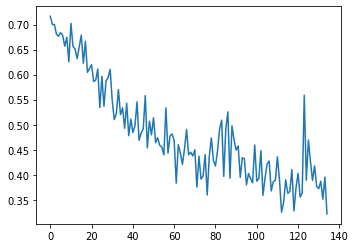

Train, it: 134 loss: 0.32
train loss:  0.3631266951560974


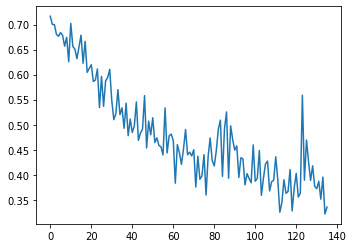

Train, it: 135 loss: 0.34
train loss:  0.3733934164047241


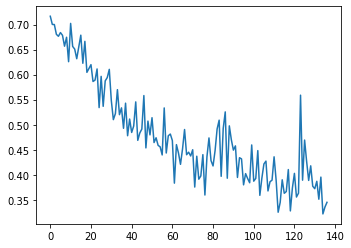

Train, it: 136 loss: 0.34
train loss:  0.3933801054954529


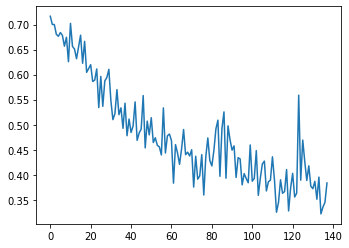

Train, it: 137 loss: 0.38
train loss:  0.3493431508541107


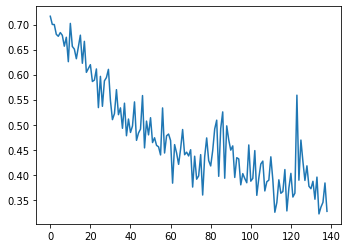

Train, it: 138 loss: 0.33
train loss:  0.42769601941108704


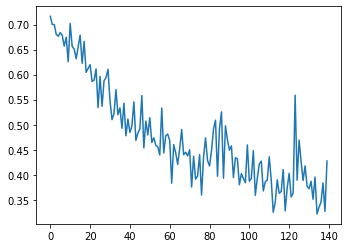

Train, it: 139 loss: 0.43
train loss:  0.3349401354789734


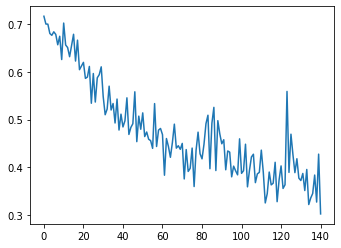

Train, it: 140 loss: 0.30
train loss:  0.30812159180641174


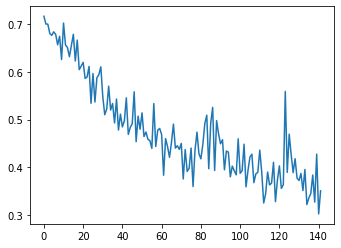

Train, it: 141 loss: 0.35
train loss:  0.3949861526489258


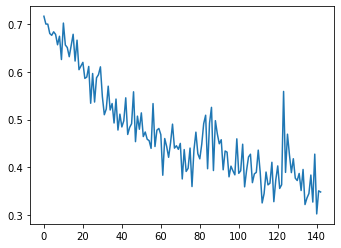

Train, it: 142 loss: 0.35
train loss:  0.3456491529941559


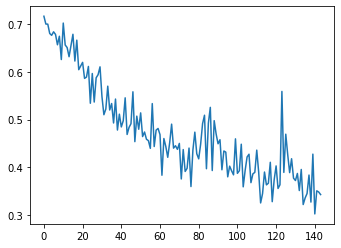

Train, it: 143 loss: 0.34
train loss:  0.32909438014030457


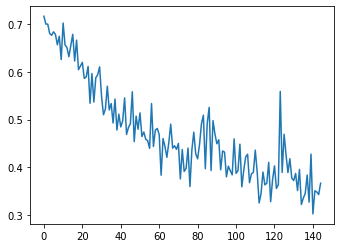

Train, it: 144 loss: 0.37
train loss:  0.32963141798973083


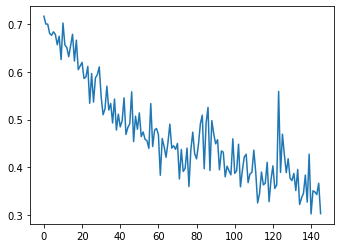

Train, it: 145 loss: 0.30
train loss:  0.33259299397468567


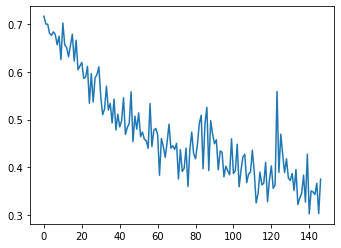

Train, it: 146 loss: 0.37
train loss:  0.40574881434440613


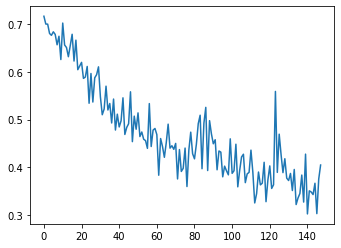

Train, it: 147 loss: 0.40
train loss:  0.3410470187664032


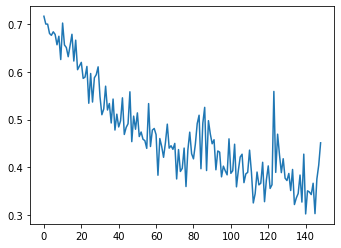

Train, it: 148 loss: 0.45
train loss:  0.397125244140625


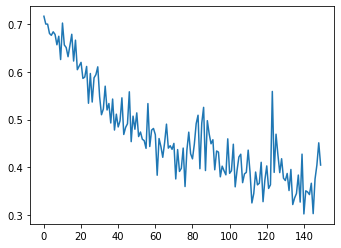

Train, it: 149 loss: 0.40
train loss:  0.40407469868659973


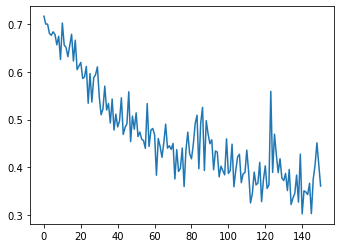

Train, it: 150 loss: 0.36
train loss:  0.37110409140586853


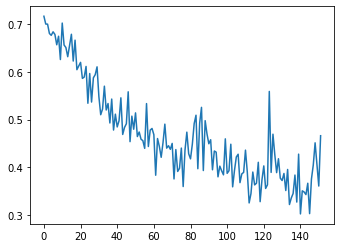

Train, it: 151 loss: 0.47
train loss:  0.4023030400276184


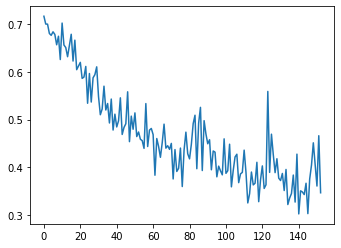

Train, it: 152 loss: 0.35
train loss:  0.424632728099823


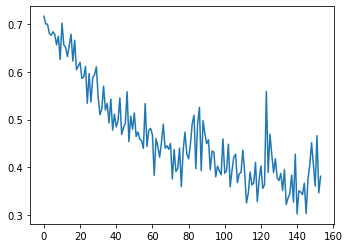

Train, it: 153 loss: 0.38
train loss:  0.34984856843948364


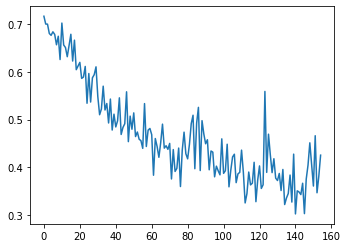

Train, it: 154 loss: 0.43
train loss:  0.40081852674484253


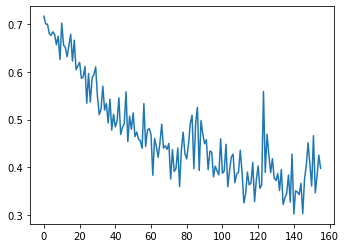

Train, it: 155 loss: 0.40
train loss:  0.3624168634414673


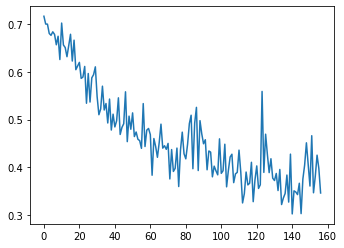

Train, it: 156 loss: 0.35
train loss:  0.34699228405952454


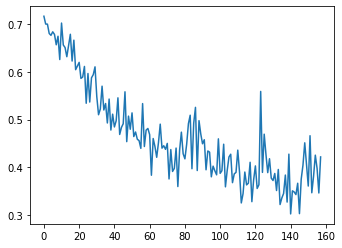

Train, it: 157 loss: 0.42
train loss:  0.31133776903152466


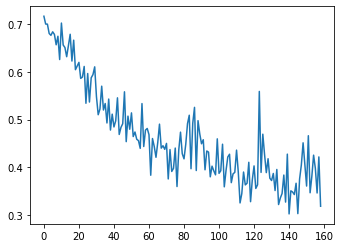

Train, it: 158 loss: 0.32
train loss:  0.3587804138660431


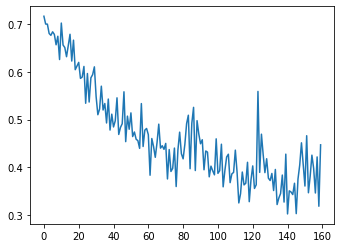

Train, it: 159 loss: 0.45
train loss:  0.358320951461792


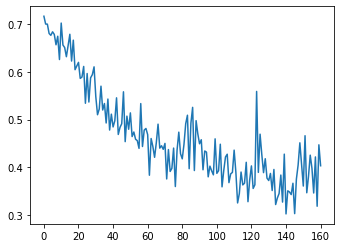

Train, it: 160 loss: 0.40
train loss:  0.35881155729293823


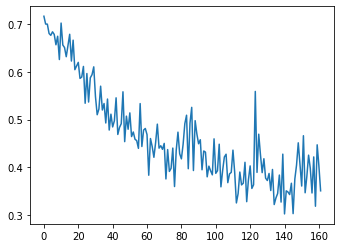

Train, it: 161 loss: 0.35
train loss:  0.32630255818367004


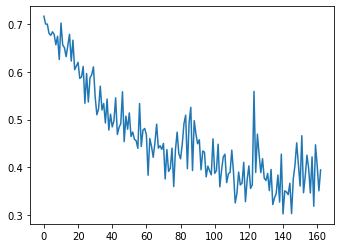

Train, it: 162 loss: 0.39
train loss:  0.38489073514938354


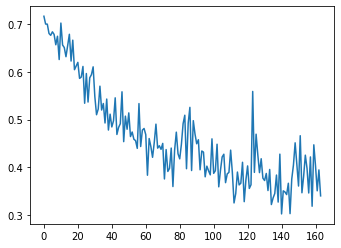

Train, it: 163 loss: 0.34
train loss:  0.3427789509296417


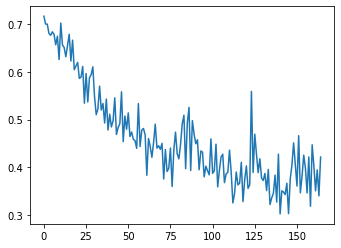

Train, it: 164 loss: 0.42
train loss:  0.3770337402820587


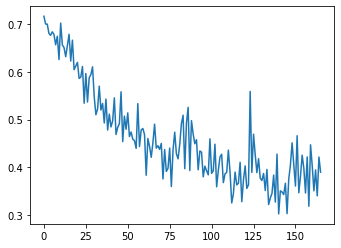

Train, it: 165 loss: 0.39
train loss:  0.3170824348926544


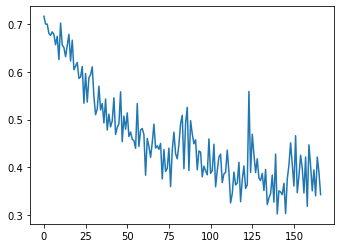

Train, it: 166 loss: 0.34
train loss:  0.33013203740119934


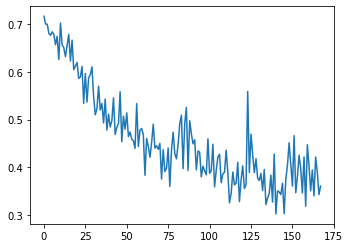

Train, it: 167 loss: 0.36
train loss:  0.31721577048301697


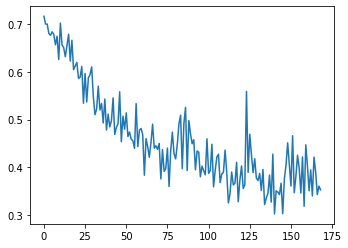

Train, it: 168 loss: 0.35
train loss:  0.3035741448402405


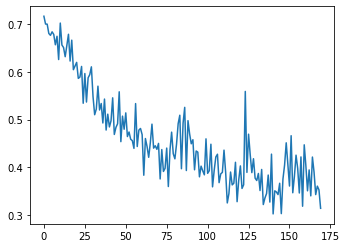

Train, it: 169 loss: 0.31
train loss:  0.3577682375907898


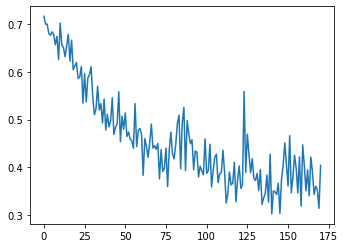

Train, it: 170 loss: 0.40
train loss:  0.34278249740600586


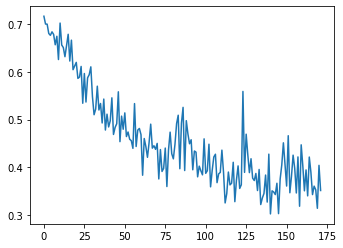

Train, it: 171 loss: 0.35
train loss:  0.3129003345966339


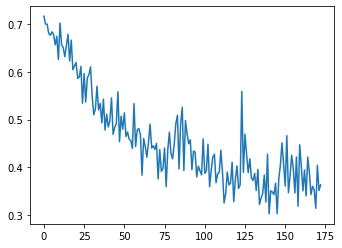

Train, it: 172 loss: 0.36
train loss:  0.3262079656124115


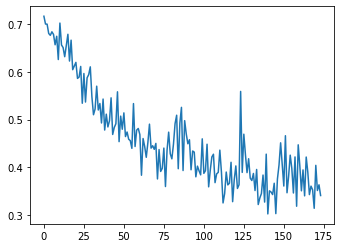

Train, it: 173 loss: 0.34
train loss:  0.2987731397151947


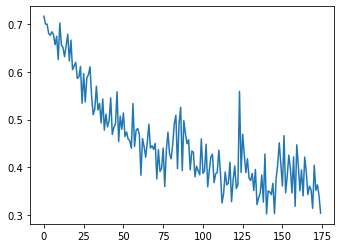

Train, it: 174 loss: 0.30
train loss:  0.29635605216026306


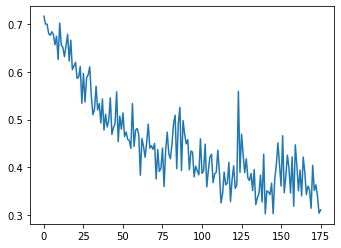

Train, it: 175 loss: 0.31
train loss:  0.29738807678222656


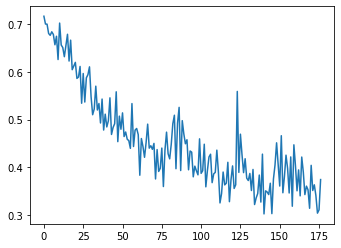

Train, it: 176 loss: 0.37
train loss:  0.3139099180698395


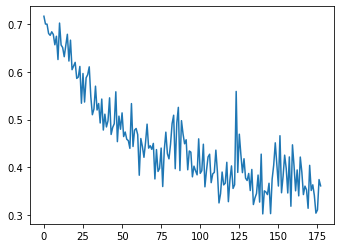

Train, it: 177 loss: 0.36
train loss:  0.3139849305152893


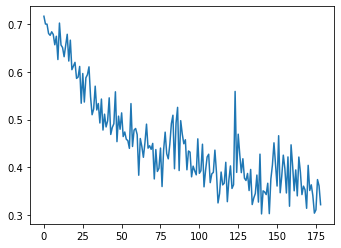

Train, it: 178 loss: 0.32
train loss:  0.38783392310142517


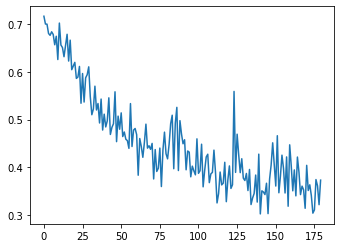

Train, it: 179 loss: 0.37
train loss:  0.3546781837940216


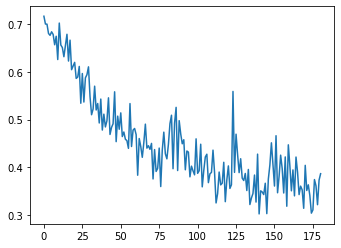

Train, it: 180 loss: 0.39
train loss:  0.31055331230163574


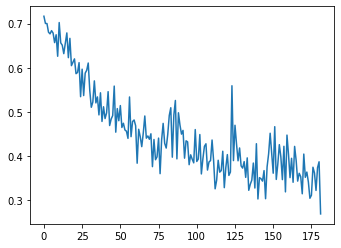

Train, it: 181 loss: 0.27
train loss:  0.35286539793014526


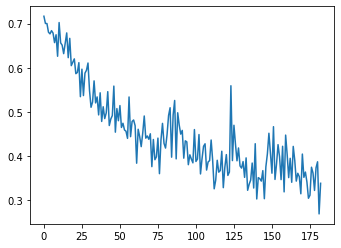

Train, it: 182 loss: 0.34
train loss:  0.3614165782928467


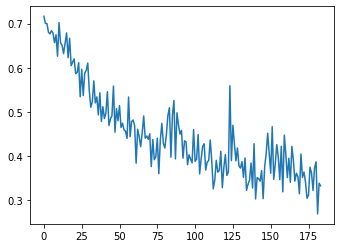

Train, it: 183 loss: 0.33
train loss:  0.3285771608352661


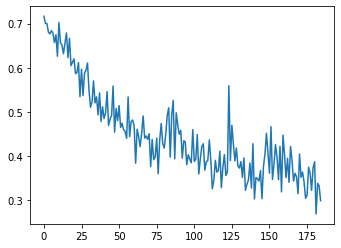

Train, it: 184 loss: 0.30
train loss:  0.32080262899398804


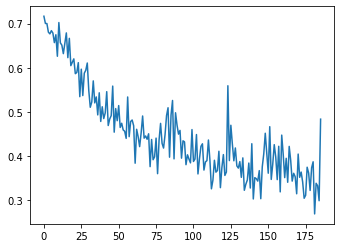

Train, it: 185 loss: 0.48
train loss:  0.33361488580703735


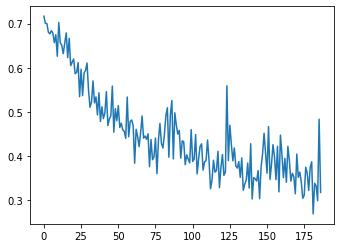

Train, it: 186 loss: 0.32
train loss:  0.2806738317012787


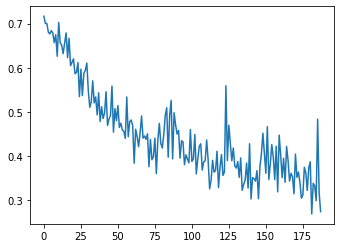

Train, it: 187 loss: 0.27
train loss:  0.3104335367679596


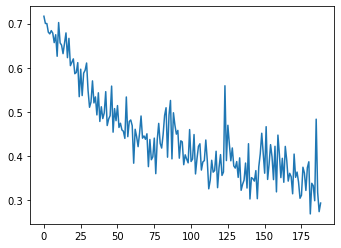

Train, it: 188 loss: 0.29
train loss:  0.31763699650764465


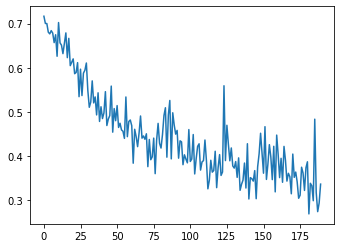

Train, it: 189 loss: 0.34
train loss:  0.2842716872692108


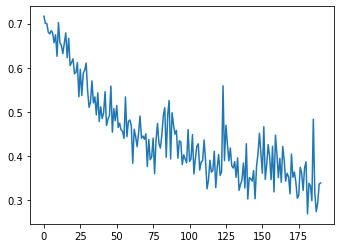

Train, it: 190 loss: 0.34
train loss:  0.3012641966342926


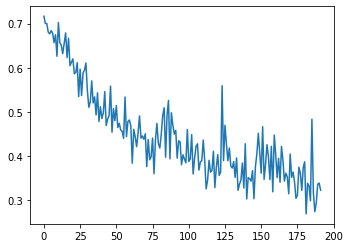

Train, it: 191 loss: 0.32
train loss:  0.3354641795158386


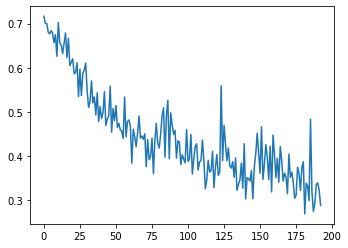

Train, it: 192 loss: 0.29
train loss:  0.3046205937862396


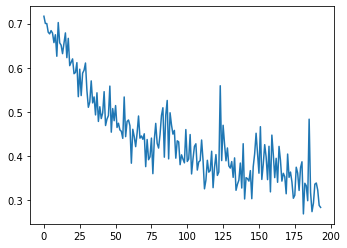

Train, it: 193 loss: 0.28
train loss:  0.39799171686172485


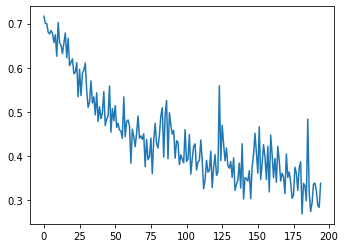

Train, it: 194 loss: 0.34
train loss:  0.3280665874481201


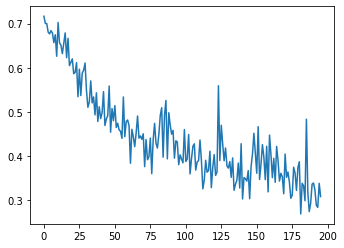

Train, it: 195 loss: 0.31
train loss:  0.30258843302726746


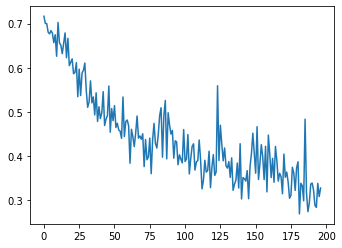

Train, it: 196 loss: 0.33
train loss:  0.3073462247848511


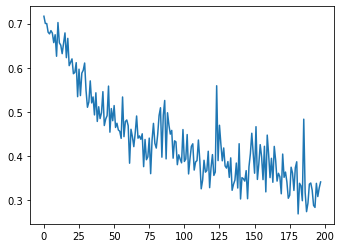

Train, it: 197 loss: 0.34
train loss:  0.32149288058280945


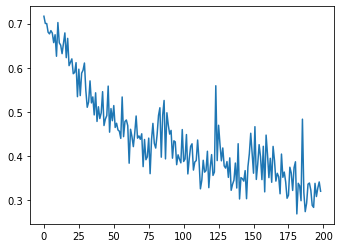

Train, it: 198 loss: 0.32
train loss:  0.33872634172439575


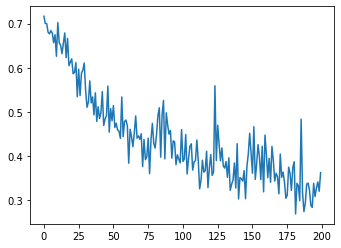

Train, it: 199 loss: 0.36


In [21]:
max_iter = 200
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train network
net.train()
for i in range(max_iter):
    train_iter.append(i)
    cur_loss = 0
    batch_iter = 0
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        cur_loss += float(get_numpy(batch_loss))
        batch_iter = j + 1
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if j % 5 == 0:
            print("train loss: ", cur_loss / (j+1))

    cur_loss /= batch_iter
    train_loss.append(cur_loss)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.show()
    # clear_output(wait=True)

    print("Train, it: {} loss: {:.2f}".format(i, train_loss[-1]))


input shape: torch.Size([1, 3, 522, 775])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


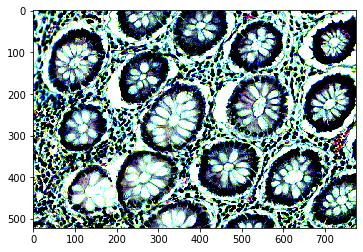

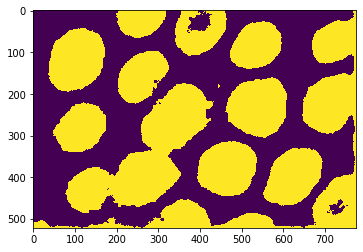

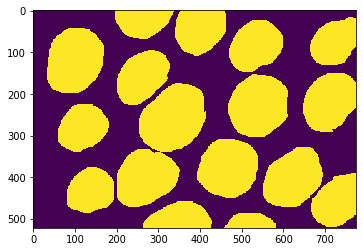

In [24]:
for batch_data in dataloader_observe:
    fig_img = plt.figure()
    inputs = get_variable(Variable(batch_data['image']))
    anno = batch_data['annotation']
    output = net(inputs)
    print('input shape:', inputs.shape)
    plt.imshow(get_numpy(inputs[0].permute(1, 2, 0)))
    plt.show()
    fig_img.suptitle('image')
    out1 = get_numpy(output[0][0])
    out1[out1>0] = 1
    out1[out1<0] = 0
    plt.imshow(out1)
    # plt.show()
    # out2 = get_numpy(output[0][1])
    # out2[out2>0] = 0
    # out2[out2<0] = 1
    # plt.imshow(out2)
    plt.show()
    plt.imshow(anno[0][0])
    plt.show()
    break

In [25]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
print(get_numpy(loss))

0.21333696
